# **CSD458 HW5:** Classify Fashion MNist images using CNNs



### **PART A: Training Convolutional Neural Networks (CNNs)**


In [1]:
!pip install torchinfo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.v2 as v2
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST

from torchinfo import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#### 1. Download the Fashion Mnist Dataset



Loading the Fashion MNIST dataset is straightforward thanks to `torchvision.datasets`:

In [178]:
datapath = 'data'

data_train = FashionMNIST(
    root=datapath,
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

# will actually be used for validation not testing
data_test = FashionMNIST(
    root=datapath,
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

#### 2. Define the Dataset, Dataloader, Transforms. Use v2.Compose() to include even more transforms, such as rotations, crops and others.



We augment the dataset by applying random tranformations between affine operations, horizontal flipping and rotation (all of them to a fairly limited degree, so that our generated data still reflect the dataset). We use these augmentations to extend the dataset to 3 times its initial size, and hopefully these altered images will help with preventing overfitting by improving the generalisation of our model. After applying these tranformations and combining them with the original images, we normalise the data to the range [0,1].

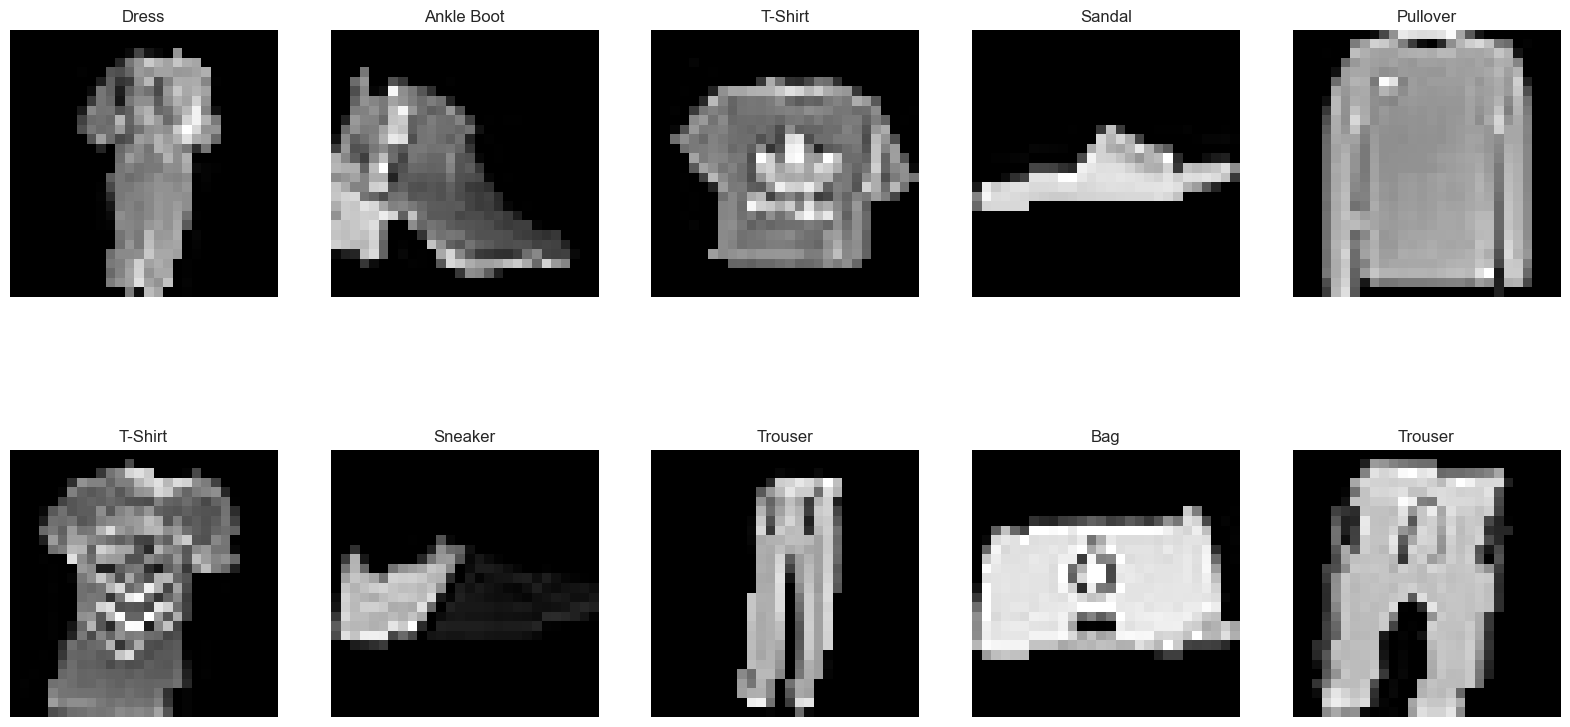

In [179]:
augments = v2.Compose([
    v2.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.9, 1), shear=5),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(5),
])

new_imgs = torch.cat((augments(data_train.data), augments(data_train.data), augments(data_train.data)), 0)
new_labels = torch.cat((data_train.targets, data_train.targets, data_train.targets), 0)

data_aug = torch.utils.data.TensorDataset(new_imgs, new_labels)

# show 10 random augmented images
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axs.flatten()):
    idx = np.random.randint(0, len(new_imgs))
    ax.imshow(new_imgs[idx].squeeze(), cmap='gray')
    ax.set_title(labels_map[new_labels[idx].item()])
    ax.axis('off')
plt.show()

In [176]:
class AugmentedFashionMNIST(Dataset):

    def __init__(self, original, augments=None, factor=2, augmented=None, transform=None):
        if augments is None:
            augments = v2.Compose([
                v2.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.9, 1), shear=5),
                v2.RandomHorizontalFlip(),
                v2.RandomRotation(5),
            ])
        self.augments = augments

        self.transform = transform

        if augmented is None:
            data_aug = torch.cat(([augments(original.data) for _ in range(factor)]), 0)
            targets_aug = torch.cat(([original.targets for _ in range(factor)]), 0)
            augmented = (data_aug, targets_aug)

        data_aug, targets_aug = augmented
        self.data = torch.cat((original.data, data_aug), 0).reshape(-1, 1, 28, 28) / 255
        self.targets = torch.cat((original.targets, targets_aug), 0)

    def to(self, device):
        self.data = self.data.to(device)
        self.targets = self.targets.to(device)
        return self

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.transform is not None:
            return self.transform(self.data[idx]), self.targets[idx]

        return self.data[idx], self.targets[idx]

data_train_aug = AugmentedFashionMNIST(data_train, augmented=(new_imgs, new_labels)).to(device)

In [217]:
aug_tensor = v2.Compose([augments, transforms.ToTensor()])

data_train_aug = FashionMNIST(
    root=datapath,
    train=True,
    transform=aug_tensor,
    download=True
)

DataLoader, just for demonstration since it will probably change later according to chosen batch size.

In [6]:
batch_size = 128

train_loader = DataLoader(
    data_train,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=2
)

test_loader = DataLoader(
    data_test,
    batch_size=512,
    shuffle=False,
    pin_memory=True,
    num_workers=2
)

#### 3. Make your own version of CNN and report the validation set accuracy



A basic CNN with 2 conv/maxpool blocks (5x5, 3x3) and a single FC layer:

In [241]:
class CNN(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32 * 7 * 7, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)

        return x

model = CNN(n_classes=10).to(device)
summary(model=model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 28, 28]           416
├─MaxPool2d: 1-2                         [1, 16, 14, 14]           --
├─Conv2d: 1-3                            [1, 32, 14, 14]           4,640
├─MaxPool2d: 1-4                         [1, 32, 7, 7]             --
├─Linear: 1-5                            [1, 10]                   15,690
Total params: 20,746
Trainable params: 20,746
Non-trainable params: 0
Total mult-adds (M): 1.25
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 0.08
Estimated Total Size (MB): 0.24

Functions to avoid writing boilerplate code all over again later:

In [158]:
from tqdm.notebook import tqdm, trange

def evaluate(model, data_loader, loss):
    model.eval()
    total = 0
    correct = 0
    l = 0

    with torch.no_grad():
        model.to(device)
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            out = model(images)
            # y_pred = F.softmax(out).argmax(axis=-1)
            y_pred = out.argmax(axis=-1)
            total += len(labels)
            correct += sum(y_pred == labels).item()

            l += loss(out, labels).item()

    return correct / total, l / len(data_loader)


def plot_results(train_accs, valid_accs, train_losses, valid_losses):
    n_epochs = len(train_accs)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

    ax[0].plot(train_losses, label='train')
    ax[0].plot(valid_losses, label='validation')
    ax[0].set_title('Loss')
    ax[0].legend()

    ax[1].plot(train_accs, label='train')
    ax[1].plot(valid_accs, label='validation')
    ax[1].set_title('Accuracy')
    ax[1].legend()

    ax[1].set_xticks(range(n_epochs), range(1, n_epochs+1))
    ax[1].set_xlabel('Epoch')
    ax[1].set_xlim(0, n_epochs-1)

    plt.show()


def train_model(model, n_epochs=6, lr=1e-3, batch_size=128, optimizer=None, loss=None, plot=True, aug_data=True, n_workers=0,):
    global data_train, data_train_aug, data_test

    if aug_data:
        train_set = data_train_aug
    else:
        train_set = data_train

    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=train_set.data.device.type != 'cuda',
        num_workers=n_workers
    )

    test_loader = DataLoader(
        data_test,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=data_test.data.device.type != 'cuda',
        num_workers=n_workers
    )

    train_accs, valid_accs = np.zeros((2, n_epochs))
    train_losses, valid_losses = np.zeros((2, n_epochs))

    model = model.to(device)
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if loss is None:
        loss = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        model.train()
        for x_batch, y_batch in tqdm((train_loader), total=len(train_loader)):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            out = model(x_batch)
            l = loss(out, y_batch)
            l.backward()
            optimizer.step()

        print(f"Epoch {epoch+1:02d}:", end=' ')
        train_acc, train_loss = evaluate(model, train_loader, loss)
        valid_acc, valid_loss = evaluate(model, test_loader, loss)
        train_accs[epoch] = train_acc
        valid_accs[epoch] = valid_acc
        train_losses[epoch] = train_loss
        valid_losses[epoch] = valid_loss
        print(f"train accuracy = {train_accs[epoch]:.4f} | validation accuracy = {valid_accs[epoch]:.4f}")

    if plot:
        plot_results(train_accs, valid_accs, train_losses, valid_losses)

    return (train_accs, valid_accs), (train_losses, valid_losses)

First run: baseline model without augmented data

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 01: train accuracy = 0.8384 | validation accuracy = 0.8278


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 02: train accuracy = 0.8669 | validation accuracy = 0.8574


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 03: train accuracy = 0.8748 | validation accuracy = 0.8648


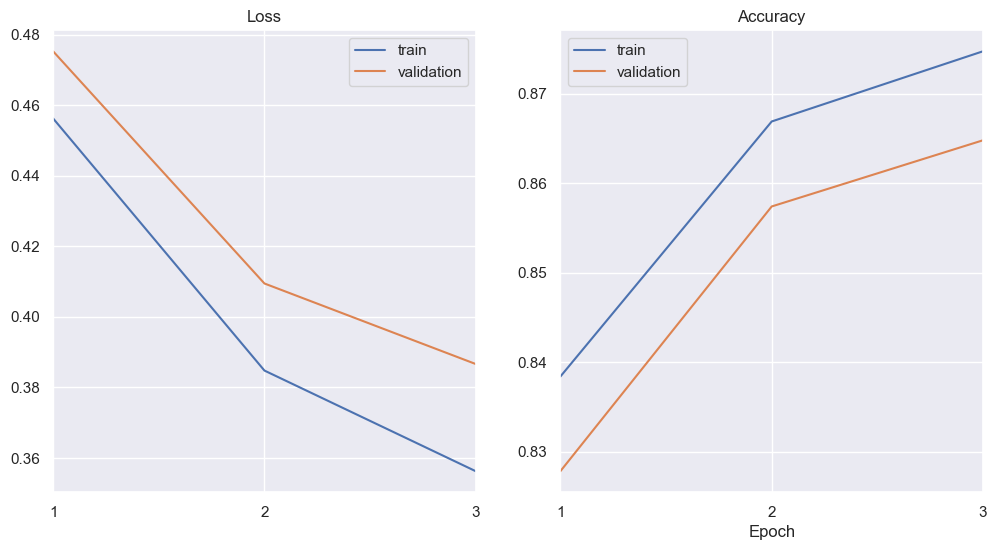

In [183]:
lr = 1e-3
n_epochs = 3
batch_size = 256

model = CNN().to(device)

train_model(model, n_epochs=n_epochs, lr=lr, batch_size=batch_size, aug_data=False);

Now the same model with augmented data:

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 01: train accuracy = 0.7608 | validation accuracy = 0.7562


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 02: train accuracy = 0.8016 | validation accuracy = 0.8186


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 03: train accuracy = 0.8093 | validation accuracy = 0.8330


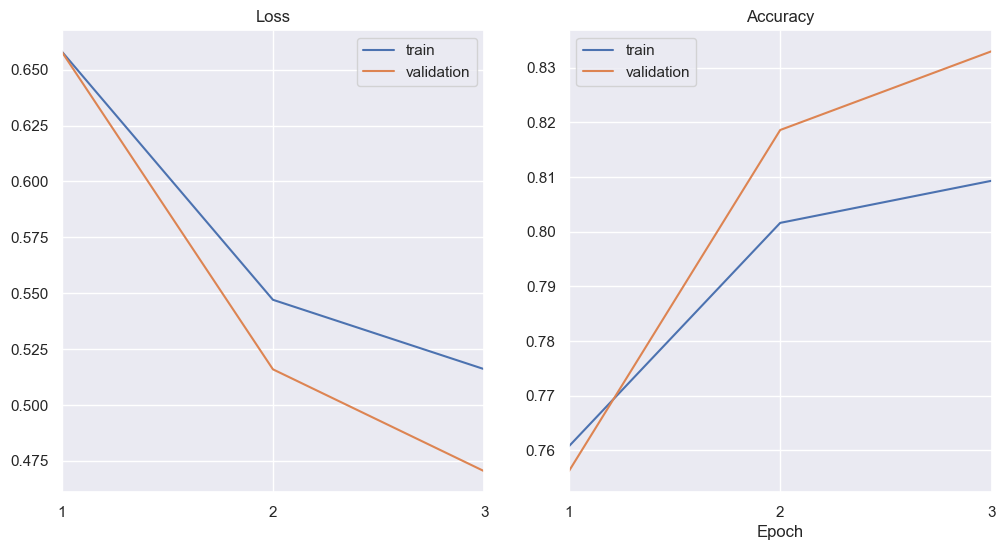

In [242]:
lr = 1e-3
n_epochs = 3
batch_size = 256

model = CNN().to(device)

train_model(model, n_epochs=n_epochs, lr=lr, batch_size=batch_size, aug_data=True);

Firstly, we can see that the augmented data really do help with the model performance, so we will be using them in the next experiments. Additionally, the model clearly hasn't converged and could have even better performance, but this is just a demonstration on a basic model. Next, we'll make 2 variations that extend this model and assess their performance more closely.

#### 4. Make 2 variations of CNNs (using different convolutions or pooling parameters) and compare them.



First variation: gelu, batchnorm, dropout, modified kernel sizes and number of filters

In [210]:
class CNN1(nn.Module):
    def __init__(self, n_classes=10, out_channels=(32, 64)):
        super().__init__()
        self.conv1 = nn.Conv2d(1, out_channels[0], 7, padding=3)
        self.bn1 = nn.BatchNorm2d(out_channels[0])
        self.conv2 = nn.Conv2d(out_channels[0], out_channels[1], 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels[1])

        self.pool = nn.MaxPool2d(2, 2)
        self.drop05 = nn.Dropout(0.6)
        self.drop02 = nn.Dropout(0.3)

        self.fc1 = nn.Linear(out_channels[1] * 7 * 7, n_classes)

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.pool(F.gelu(x))
        x = self.drop02(x)
        x = self.bn2(self.conv2(x))
        x = self.pool(F.gelu(x))
        x = torch.flatten(x, 1)
        x = self.drop05(x)
        x = self.fc1(x)

        return x

summary(CNN1(), input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1                                     [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           1,600
├─BatchNorm2d: 1-2                       [1, 32, 28, 28]           64
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Dropout: 1-4                           [1, 32, 14, 14]           --
├─Conv2d: 1-5                            [1, 64, 14, 14]           18,496
├─BatchNorm2d: 1-6                       [1, 64, 14, 14]           128
├─MaxPool2d: 1-7                         [1, 64, 7, 7]             --
├─Dropout: 1-8                           [1, 3136]                 --
├─Linear: 1-9                            [1, 10]                   31,370
Total params: 51,658
Trainable params: 51,658
Non-trainable params: 0
Total mult-adds (M): 4.91
Input size (MB): 0.00
Forward/backward pass size (MB): 0.60
Params size (MB): 0.21
Estimated Total Size (MB): 0.81

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 01: train accuracy = 0.8678 | validation accuracy = 0.8647


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 02: train accuracy = 0.8889 | validation accuracy = 0.8811


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 03: train accuracy = 0.8941 | validation accuracy = 0.8887


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 04: train accuracy = 0.9021 | validation accuracy = 0.8942


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 05: train accuracy = 0.9049 | validation accuracy = 0.8951


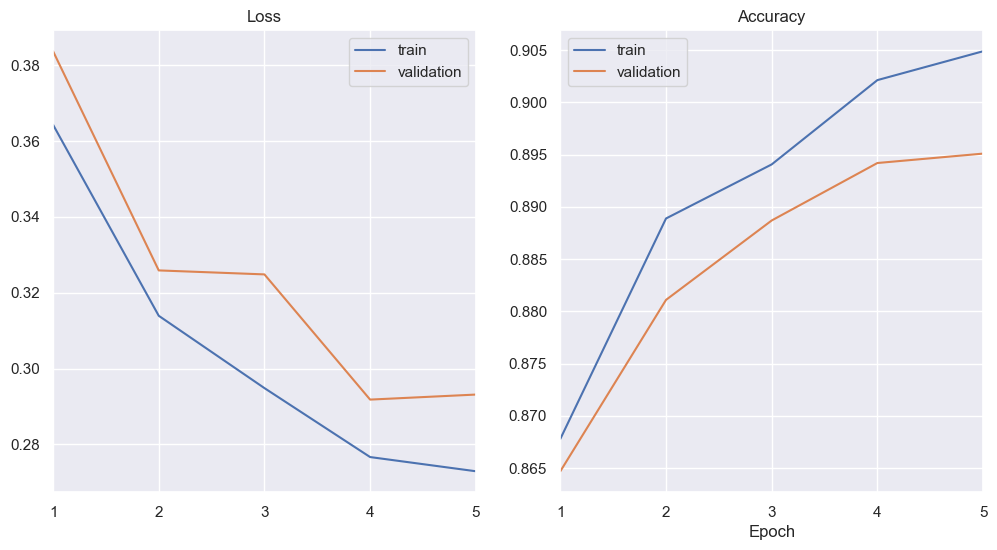

In [213]:
lr = 8e-4
n_epochs = 5
batch_size = 256

model = CNN1().to(device)

train_model(model, n_epochs=n_epochs, lr=lr, batch_size=batch_size);

We can see that this second model with more filters (convolution channels), GELU instead of RELU and the added BatchNormalisation & Dropout layers, performs quite better than the base model (1-1.5% better accuracy).

Second variation: previous + residual connections, modified kernel sizes and number of filters

In [214]:
class CNN2(nn.Module):
    def __init__(self, n_classes=10, out_channels=(32, 64)):
        super().__init__()
        self.selfconv1 = nn.Conv2d(1, out_channels[0], 1)
        self.conv1 = nn.Conv2d(1, out_channels[0], 7, padding=3)
        self.bn1 = nn.BatchNorm2d(out_channels[0])
        self.selfconv2 = nn.Conv2d(1, out_channels[1], 1, stride=2)
        self.conv2 = nn.Conv2d(out_channels[0], out_channels[1], 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels[1])

        self.pool = nn.MaxPool2d(2, 2)
        self.drop05 = nn.Dropout(0.5)
        self.drop02 = nn.Dropout(0.2)

        self.fc1 = nn.Linear(out_channels[1] * 7 * 7, n_classes)

    def forward(self, x):
        x_ = self.selfconv1(x)
        y = self.bn1(self.conv1(x))
        y = self.pool(F.gelu(y + x_))
        y = self.drop02(y)
        x_ = self.selfconv2(x)
        y = self.bn2(self.conv2(y))
        y = self.pool(F.gelu(y + x_))
        y = torch.flatten(y, 1)
        y = self.drop05(y)
        y = self.fc1(y)

        return y


summary(CNN2(), input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN2                                     [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           64
├─Conv2d: 1-2                            [1, 32, 28, 28]           1,600
├─BatchNorm2d: 1-3                       [1, 32, 28, 28]           64
├─MaxPool2d: 1-4                         [1, 32, 14, 14]           --
├─Dropout: 1-5                           [1, 32, 14, 14]           --
├─Conv2d: 1-6                            [1, 64, 14, 14]           128
├─Conv2d: 1-7                            [1, 64, 14, 14]           18,496
├─BatchNorm2d: 1-8                       [1, 64, 14, 14]           128
├─MaxPool2d: 1-9                         [1, 64, 7, 7]             --
├─Dropout: 1-10                          [1, 3136]                 --
├─Linear: 1-11                           [1, 10]                   31,370
Total params: 51,850
Trainable params: 51,850
Non-trainable params: 0
To

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 01: train accuracy = 0.8826 | validation accuracy = 0.8803


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 02: train accuracy = 0.8890 | validation accuracy = 0.8843


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 03: train accuracy = 0.9087 | validation accuracy = 0.9002


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 04: train accuracy = 0.9131 | validation accuracy = 0.9033


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 05: train accuracy = 0.9159 | validation accuracy = 0.9067


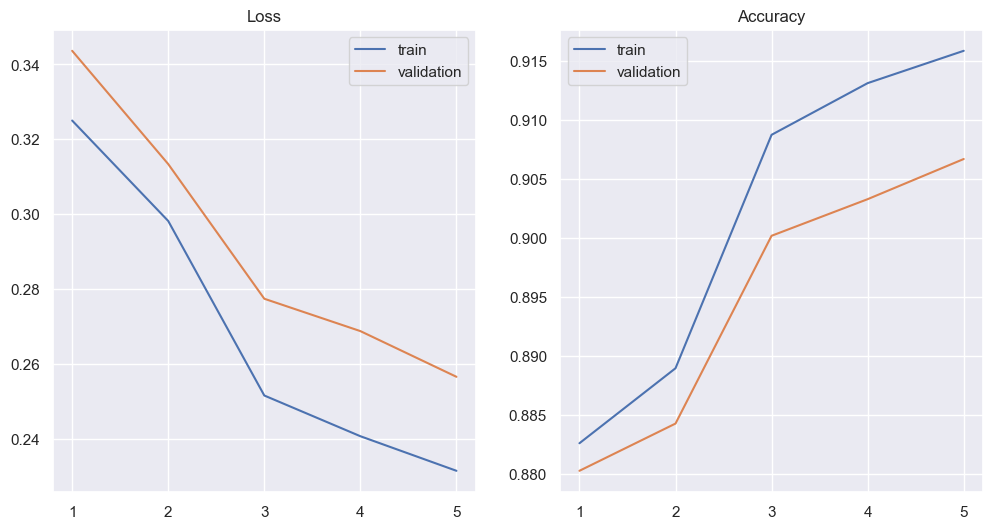

In [201]:
lr = 8e-3
n_epochs = 5
batch_size = 256

model = CNN2().to(device)

train_model(model, n_epochs=n_epochs, lr=lr, batch_size=batch_size, plot=True);

This third model takes the performance a step further and even breaks the 90% accuracy barrier (getting closer to 91%). It has all the same improvements as the previous model, but furthermore adds residual connections. It's a good performance for a model that still really only has 2 convolutional layers.

#### 5. Increase the number of Layers of the CNN (the number of convolutions followed by pooling layers) and observe what happens, in terms of the progress of the training and validation losses and the final model accuracies.



Continuing from before, we can use 2 full residual blocks (2 conv layers in each) to create a deeper model and compare the performance:

In [289]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels=(32, 64), kernel_sizes=(7, 3), stride=1, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels[0], 7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm2d(out_channels[0])
        self.conv2 = nn.Conv2d(out_channels[0], out_channels[1], 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels[1])

    def forward(self, x):
        y = self.bn1(self.conv1(x))
        y = F.gelu(y)
        y = self.bn2(self.conv2(y))

        return y

class CNN3(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.res1 = ResBlock(1)
        self.res2 = ResBlock(64, (32, 16))

        self.fc1 = nn.Linear(16 * 7 * 7, 100)
        self.fc2 = nn.Linear(100, n_classes)

        self.pool = nn.MaxPool2d(2, 2)
        self.drop05 = nn.Dropout(0.5)
        self.drop02 = nn.Dropout(0.3)

        self.selfconv1 = nn.Conv2d(1, 64, 1)
        self.selfconv2 = nn.Conv2d(1, 16, 2, stride=2)

    def forward(self, x):
        y = F.gelu(self.res1(x) + self.selfconv1(x))
        y = self.pool(y)
        y = self.drop02(y)
        y = F.gelu(self.res2(y) + self.selfconv2(x))
        y = self.pool(y)
        y = torch.flatten(y, 1)
        y = self.drop05(F.gelu(self.fc1(y)))
        y = self.fc2(y)

        return y

summary(CNN3(), input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN3                                     [1, 10]                   --
├─ResBlock: 1-1                          [1, 64, 28, 28]           --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           1,600
│    └─BatchNorm2d: 2-2                  [1, 32, 28, 28]           64
│    └─Conv2d: 2-3                       [1, 64, 28, 28]           18,496
│    └─BatchNorm2d: 2-4                  [1, 64, 28, 28]           128
├─Conv2d: 1-2                            [1, 64, 28, 28]           128
├─MaxPool2d: 1-3                         [1, 64, 14, 14]           --
├─Dropout: 1-4                           [1, 64, 14, 14]           --
├─ResBlock: 1-5                          [1, 16, 14, 14]           --
│    └─Conv2d: 2-5                       [1, 32, 14, 14]           100,384
│    └─BatchNorm2d: 2-6                  [1, 32, 14, 14]           64
│    └─Conv2d: 2-7                       [1, 16, 14, 14]           4,62

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 01: train accuracy = 0.9041 | validation accuracy = 0.8977


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 02: train accuracy = 0.9227 | validation accuracy = 0.9121


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 03: train accuracy = 0.9312 | validation accuracy = 0.9187


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 04: train accuracy = 0.9282 | validation accuracy = 0.9167


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 05: train accuracy = 0.9446 | validation accuracy = 0.9243


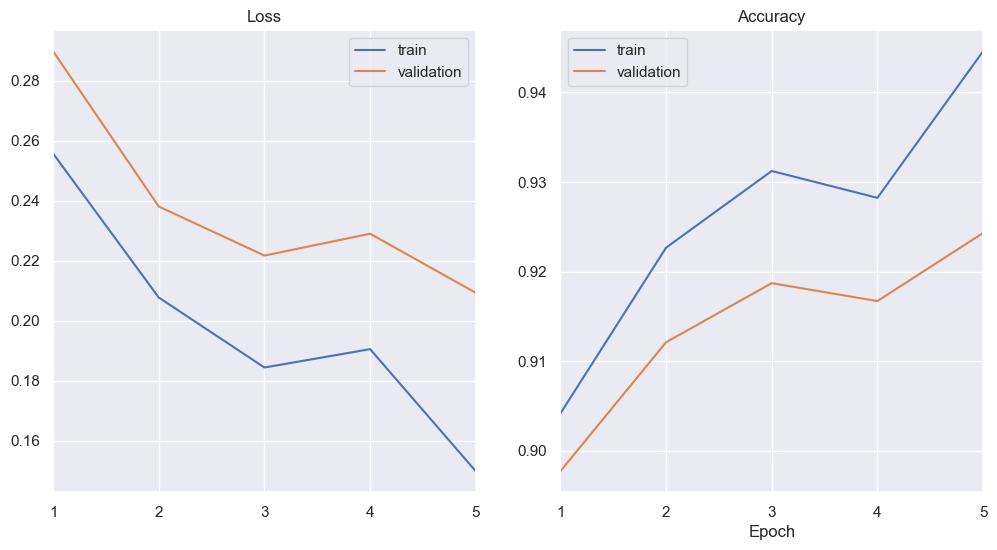

In [295]:
lr = 1e-3
n_epochs = 5
batch_size = 256

model = CNN3().to(device)

train_model(model, n_epochs=n_epochs, lr=lr, batch_size=batch_size);

In [ ]:
torch.save(model.state_dict(), './model_weights.pth')

Using this deeper model, we are able to achieve a validation accuracy of almost 92.5%, which is a significant improvement over the previous models. The model still seems to not have still converged but it has started to overfit. We can add some regularisation by means of weight decay in our optimizer and continue training just a bit more so that we can see the final performance of this model.

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 01: train accuracy = 0.9536 | validation accuracy = 0.9311


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 02: train accuracy = 0.9556 | validation accuracy = 0.9313


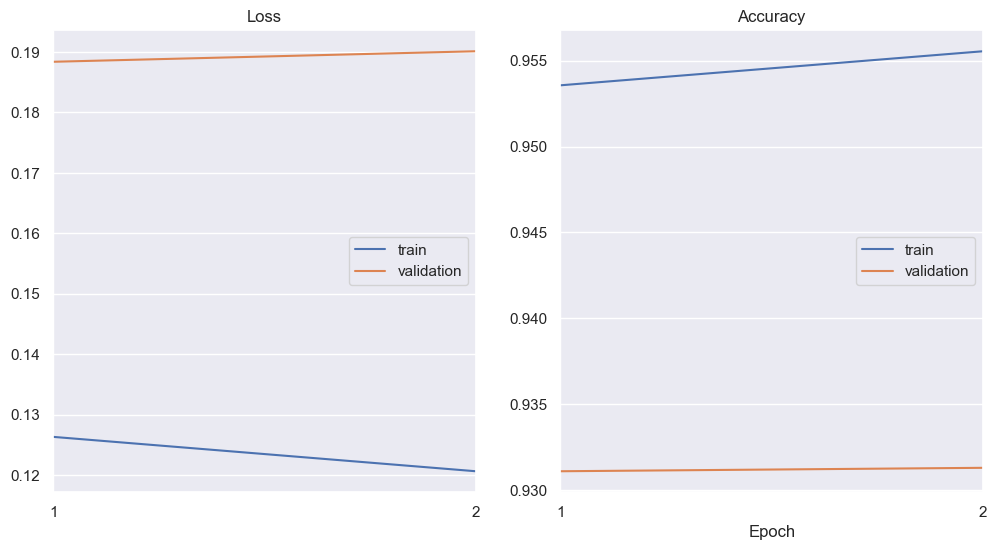

In [297]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)

train_model(model, n_epochs=2, lr=lr, batch_size=batch_size, optimizer=optimizer);

torch.save(model.state_dict(), './model_weights1.pth')

Finally, we have passed the 93% accuracy mark, while validation loss is starting to increase and validation accuracy has plateaued, so we can call this our final model.

#### 6. Visualize some of the Feature Maps and Convolution Kernels that you find interesting.

We can use a sample image as this one below, to visualise the filter maps and associated resulting filters from the first convolutional layer of the first residual block in our model:

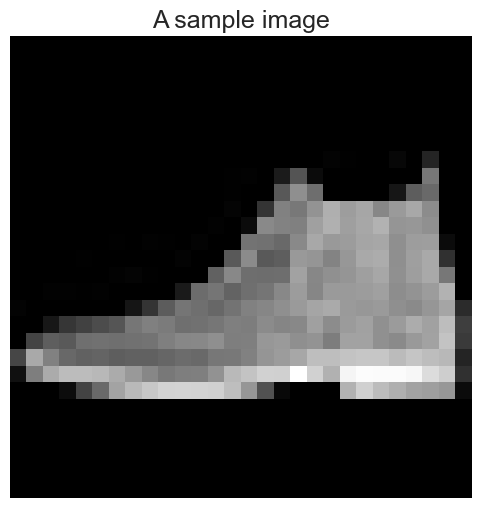

In [305]:
img = data_test.data[0]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(img.numpy(), cmap="gray")
ax.axis("off")
ax.set_title("A sample image", fontsize=18);

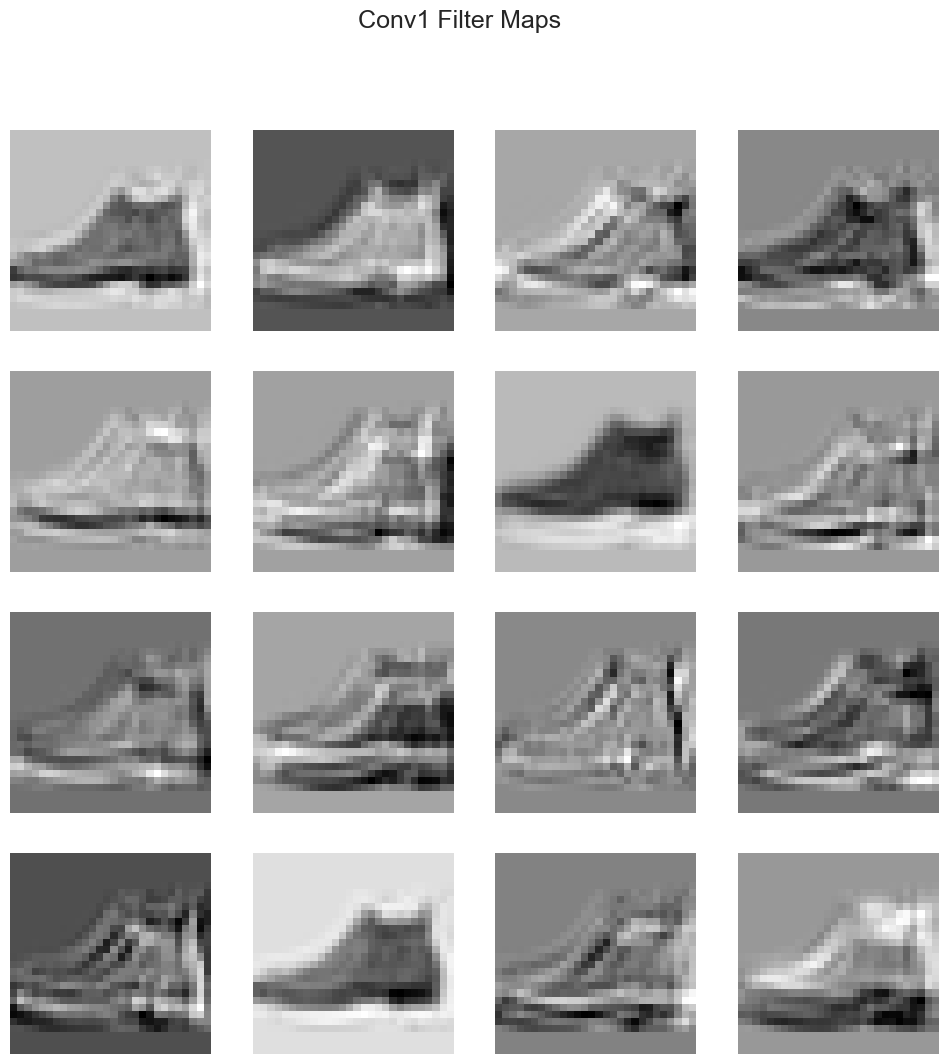

In [337]:
img = data_test.data[0].unsqueeze(0).unsqueeze(0).to(device) / 255

with torch.no_grad():
    feat_map1 = model.res1.conv1(img)
    feat_map1 = feat_map1.detach().cpu().numpy()
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))
    for i, ax in enumerate(axs.flat):
        if i < feat_map1.shape[1]: 
            ax.imshow(feat_map1[-1, i, :, :], cmap="gray")
            ax.axis('off')
        else:
            ax.axis('off')

    fig.suptitle("Conv1 Filter Maps", fontsize=18)

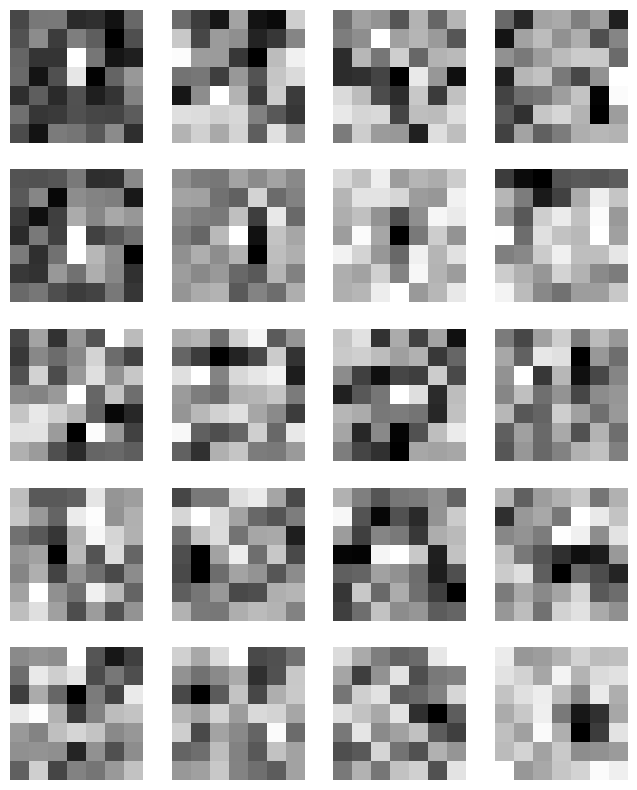

In [338]:
kernels = model.res1.conv1.weight.detach()

kernels = kernels.cpu()
kernel_size = kernels.size(2)
kernels = kernels.reshape(-1, kernel_size, kernel_size)
# select 20 of them at random
kernels = kernels[np.random.choice(kernels.size(0), 20, replace=False)]

kernels = (kernels - kernels.min()) / (kernels.max() - kernels.min())

num_kernels = kernels.size(0)

cols = int(np.sqrt(num_kernels))
rows = (num_kernels // cols) + (0 if num_kernels % cols == 0 else 1)

fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
for i, ax in enumerate(axs.flat):
    if i < num_kernels:
        kernel = kernels[i].squeeze()

        ax.imshow(kernel, cmap='gray')
        ax.axis('off')
    else:
        ax.axis('off')

plt.show()

As is usually expected from the first convolutional layer of a model, these filters seem to be detecting basic local features such as edges, corners, diagonals or other local patterns.

### **PART B: Transfer Learning**







#### 1. Load a Pretrained model (the simpler the better for computational efficiency e.g. resnet16). You are gonna use it to train your model on Fashion Mnist

In [8]:
import torchvision.models as models

resnet = models.resnet18(pretrained=True)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### 2. Freeze the BackBone of the pretrained model (Convolutions etc.) and modify the final fully connected layer/layers that perform classification (make sure the new output dimension matches the number of classes in Fashion Mnist)

In [17]:
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [166]:
data_train_aug.data_1 = data_train_aug.data.clone()
data_train_aug.data = data_train_aug.data_1.repeat(1, 3, 1, 1)
data_train_aug.data.shape, data_train_aug.data_1.shape

(torch.Size([240000, 3, 28, 28]), torch.Size([240000, 1, 28, 28]))

In [167]:
data_test.data_1 = data_test.data.clone()
data_test.data = data_test.data_1.reshape(-1, 1, 28, 28).repeat(1, 3, 1, 1)
data_test.data.shape, data_test.data_1.shape

(torch.Size([10000, 3, 28, 28]), torch.Size([10000, 28, 28]))

In [170]:
test_data = data_test.data.float().to(device) / 255
data_test = torch.utils.data.TensorDataset(test_data, data_test.targets)
data_test.data = test_data

In [147]:
data_train_aug.data_1 = data_train_aug.data_bak.clone()
data_train_aug.data_3 = data_train_aug.data.clone()
data_train_aug.data = data_train_aug.data_1.clone()
data_train_aug.data.shape

torch.Size([240000, 1, 28, 28])

In [165]:
data_train_aug.__getitem__(0)[0].shape, data_test.__getitem__(0)[0].shape

(torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))

In [173]:
resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

resnet.fc = nn.Linear(resnet.fc.in_features, 10)

summary(resnet, input_size=(1, 3, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 14, 14]           (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 14, 14]           (128)
├─ReLU: 1-3                              [1, 64, 14, 14]           --
├─MaxPool2d: 1-4                         [1, 64, 7, 7]             --
├─Sequential: 1-5                        [1, 64, 7, 7]             --
│    └─BasicBlock: 2-1                   [1, 64, 7, 7]             --
│    │    └─Conv2d: 3-1                  [1, 64, 7, 7]             (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 7, 7]             (128)
│    │    └─ReLU: 3-3                    [1, 64, 7, 7]             --
│    │    └─Conv2d: 3-4                  [1, 64, 7, 7]             (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 7, 7]             (128)
│    │    └─ReLU: 3-6                    [1, 64, 7, 7]     

In [138]:
# With square kernels and equal stride
input = torch.randn(20, 1, 28, 28)

m = nn.ConvTranspose2d(1, 3, 8, stride=8, padding=4, dilation=2, output_padding=1)
output = m(input)
output.size()

torch.Size([20, 3, 224, 224])

#### 3. Train the model on Fashion Mnist for a few epochs and log your train/val loss progress as well as the final model accuracy on the validation set.

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 01: train accuracy = 0.6616 | validation accuracy = 0.6751


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 02: train accuracy = 0.6770 | validation accuracy = 0.6899


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 03: train accuracy = 0.6854 | validation accuracy = 0.6955


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 04: train accuracy = 0.6892 | validation accuracy = 0.6974


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 05: train accuracy = 0.6918 | validation accuracy = 0.7008


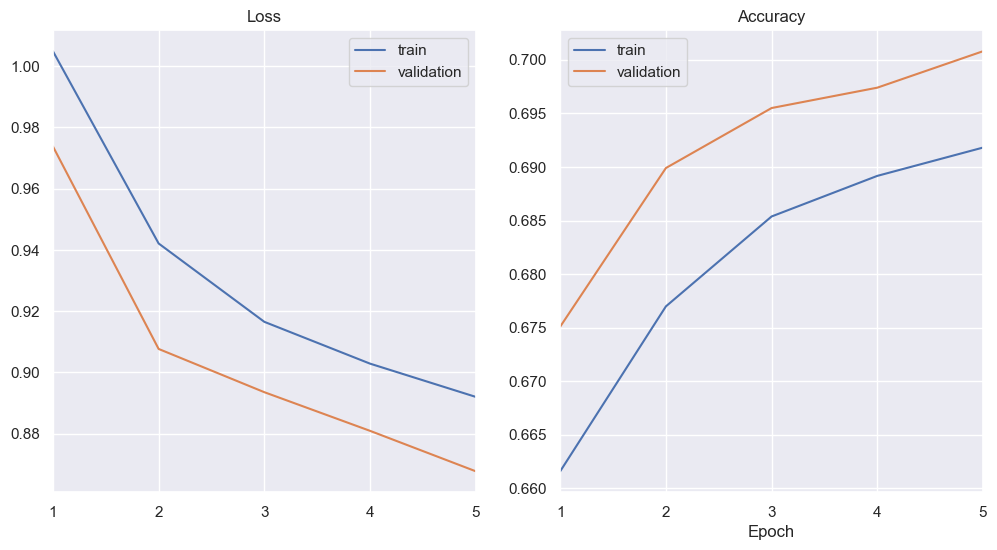

In [174]:
trainable_params = [param for param in resnet.parameters() if param.requires_grad]
# optimizer = torch.optim.Adam(trainable_params, lr=1e-3)
optimizer = torch.optim.SGD(trainable_params, lr=1e-2)

train_model(resnet, n_epochs=5, batch_size=256, optimizer=optimizer);

In [ ]:
trainable_params

We can see the frozen model doesn't really do a good job, probably because it was trained on a very different dataset (ImageNet) and the features it learned are not very useful for Fashion MNIST. We'll try unfreezing the model and fine-tuning on Fashion MNIST.

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 01: train accuracy = 0.8922 | validation accuracy = 0.8740


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 02: train accuracy = 0.9143 | validation accuracy = 0.8913


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 03: train accuracy = 0.9221 | validation accuracy = 0.8939


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 04: train accuracy = 0.9372 | validation accuracy = 0.8974


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 05: train accuracy = 0.9469 | validation accuracy = 0.9030


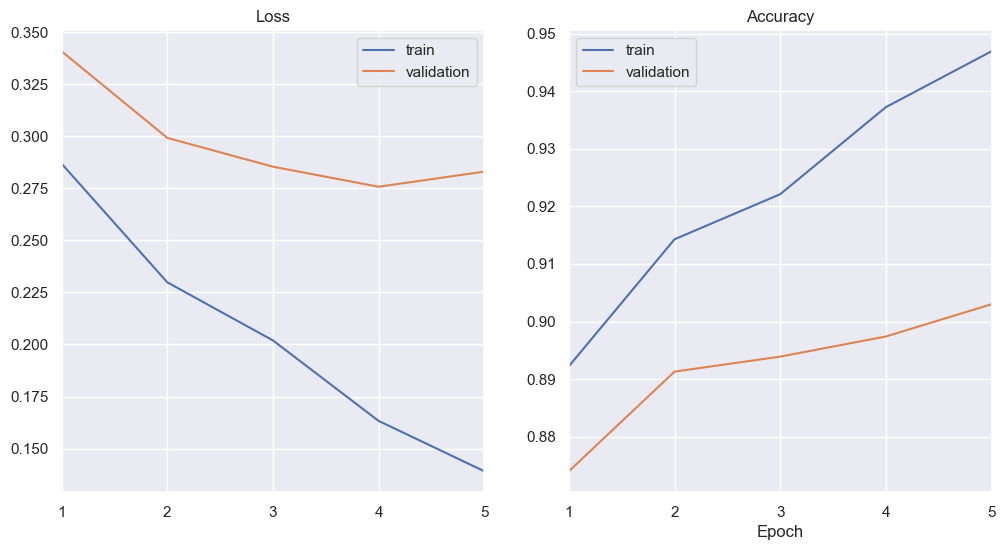

In [261]:
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
model.fc = nn.Linear(model.fc.in_features, 10)

train_model(model, n_epochs=5, lr=1e-4, batch_size=256, aug_data=True);

The model now has a much better performance, but it's still not as good as the best model we trained from scratch. This is probably because the model is too complex for the Fashion MNIST dataset, and it's overfitting. We can try to add some regularisation to the model to see if we can improve its performance.

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 01: train accuracy = 0.8133 | validation accuracy = 0.8100


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 02: train accuracy = 0.8846 | validation accuracy = 0.8836


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 03: train accuracy = 0.8789 | validation accuracy = 0.8601


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 04: train accuracy = 0.8919 | validation accuracy = 0.8879


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 05: train accuracy = 0.9123 | validation accuracy = 0.8981


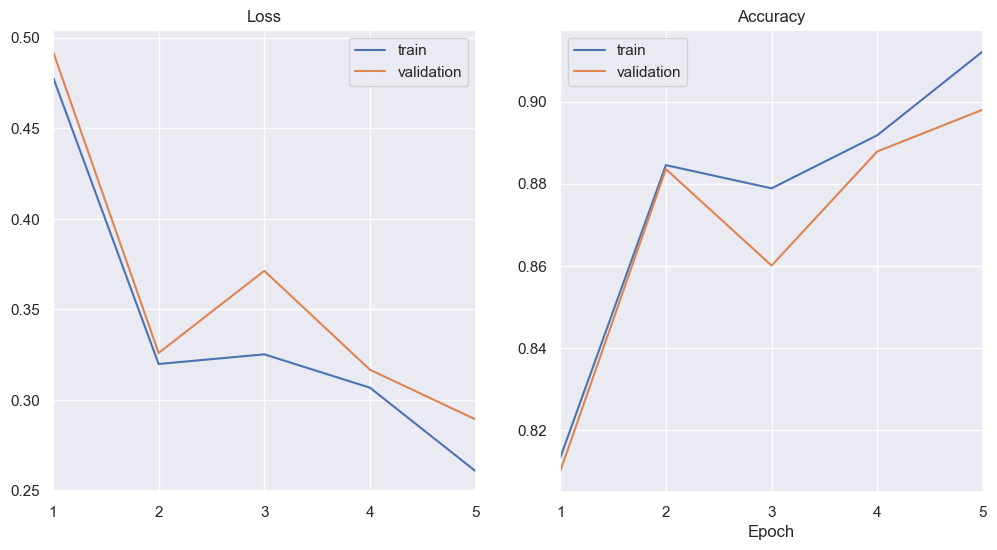

In [263]:
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
model.fc = nn.Linear(model.fc.in_features, 10)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-2)

train_model(model, n_epochs=5, lr=1e-4, batch_size=256, optimizer=optimizer, aug_data=True);

After experimenting with some values for regularisation, we can reduce the overfitting but the model still doesn't outperform our best model from previously. In order to get an idea whether this is because of the very different dataset it was trained on, or just because the model is too complex for our task, we can train it from scratch and compare the results.

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 01: train accuracy = 0.8978 | validation accuracy = 0.8891


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 02: train accuracy = 0.9054 | validation accuracy = 0.8967


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 03: train accuracy = 0.9172 | validation accuracy = 0.9022


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 04: train accuracy = 0.9204 | validation accuracy = 0.9045


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 05: train accuracy = 0.9241 | validation accuracy = 0.9057


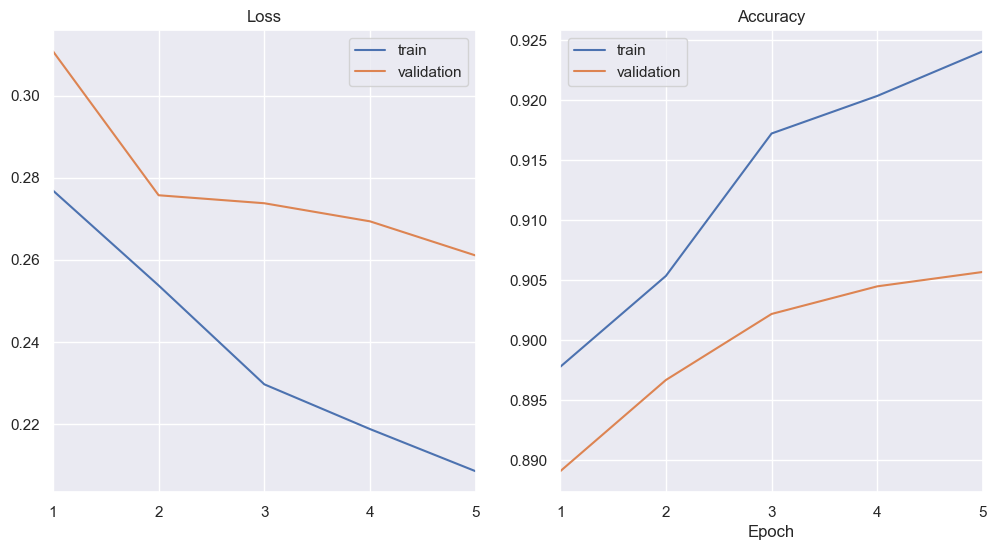

In [266]:
model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
model.fc = nn.Linear(model.fc.in_features, 10)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-3)

train_model(model, n_epochs=5, lr=1e-4, batch_size=256, optimizer=optimizer, aug_data=True);

Finally, the model trained from scratch performs better than the fine-tuned model, but not by much. This suggests that the model is too complex for the Fashion MNIST dataset, and we should probably use a simpler model for this task, like the simpler CNN from before that performed better (it actually was a simpler resnet).

#### **Optional:** If you are interested you can also unfreeze the final convolutions of the pretrained model to Fine Tune it. You can even visualize the Feature Maps of you model.

#### *Guidelines*: The goal of this assignment is that you play around a little bit with terms and notions introduced. You don' t have to train your models for ages. 5-10 epoches will suffice. We just want to see that you can make a model properly, train it and log some results.